In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../../../data/preprocessed/feature_selection_by_dicision_tree_final_data_30feature.csv')

X = df.drop(['price_per_m2'], axis=1)
y = df['price_per_m2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=6,             
    min_samples_leaf=15,   
    min_samples_split=20,     
    max_features=0.6,         
    max_samples=0.7,         
    bootstrap=True,
    ccp_alpha=0.02,           
    random_state=42,
    n_jobs=-1,
    verbose=0
)
rf_model.fit(X_train, y_train)


RandomForestRegressor(ccp_alpha=0.02, max_depth=6, max_features=0.6,
                      max_samples=0.7, min_samples_leaf=15,
                      min_samples_split=20, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [5]:
y_pred_test = rf_model.predict(X_test)
y_pred_train = rf_model.predict(X_train)

# Calculate metrics
test_r2 = r2_score(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
gap = train_r2 - test_r2

print("\n" + "="*50)
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Performance Gap: {gap:.4f} (Target: <0.03)")
print("="*50 + "\n")


Train R²: 0.9188
Test R²: 0.9070
Performance Gap: 0.0119 (Target: <0.03)



In [6]:
cv_scores = cross_val_score(
    rf_model,
    X_train,
    y_train,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

print(f"Cross-Validation R²: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")


Cross-Validation R²: 0.9078 ± 0.0088


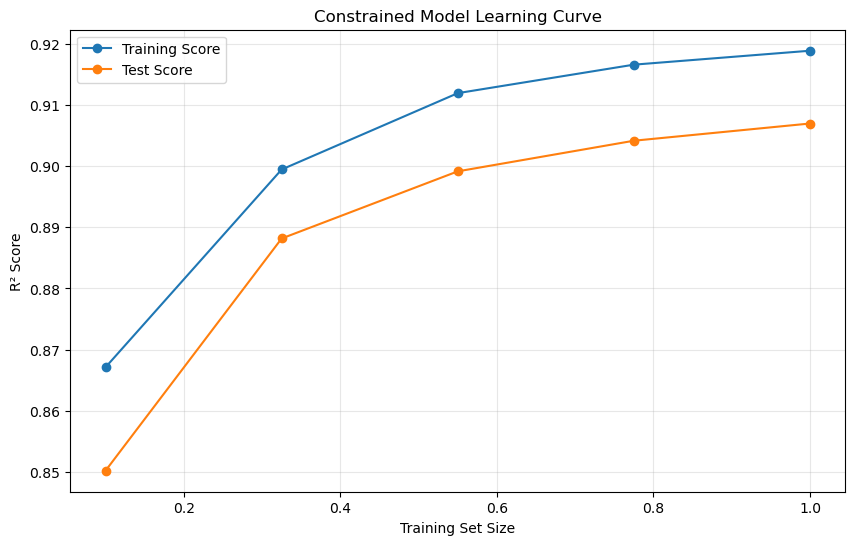

In [7]:
def plot_learning_curve(model, X, y):
    train_sizes = np.linspace(0.1, 1.0, 5)
    train_scores, test_scores = [], []
    
    for size in train_sizes:
        n_samples = int(size * X.shape[0])
        X_subset = X[:n_samples]
        y_subset = y[:n_samples]
        
        model.fit(X_subset, y_subset)
        train_scores.append(model.score(X_subset, y_subset))
        test_scores.append(model.score(X_test, y_test))
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores, 'o-', label="Training Score")
    plt.plot(train_sizes, test_scores, 'o-', label="Test Score")
    # plt.axhline(y=0.87, color='r', linestyle='--', alpha=0.5, label="Target R²")
    plt.xlabel("Training Set Size")
    plt.ylabel("R² Score")
    plt.title("Constrained Model Learning Curve")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig("constrained_model_learning_curve.png", dpi=300)
    plt.show()

plot_learning_curve(rf_model, X_train, y_train)

In [8]:
def print_metrics(y_true, y_pred, set_name):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-8))) * 100
    
    print(f"\n{set_name} Metrics:")
    print(f"R²: {r2:.4f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    if set_name == "Test":
        print(f"Avg Price: {y_true.mean():.2f}")

print_metrics(y_train, y_pred_train, "Train")
print_metrics(y_test, y_pred_test, "Test")


Train Metrics:
R²: 0.9188
MAE: 446.91
MAPE: 76.45%

Test Metrics:
R²: 0.9070
MAE: 472.99
MAPE: 75.98%
Avg Price: 1919.87


In [9]:
if test_r2 > 0.89:
    print("\nR² too high - applying additional regularization:")
    rf_model.set_params(ccp_alpha=0.02, max_depth=6)
    rf_model.fit(X_train, y_train)
    
    y_pred_test = rf_model.predict(X_test)
    test_r2 = r2_score(y_test, y_pred_test)
    print(f"New Test R²: {test_r2:.4f}")


R² too high - applying additional regularization:
New Test R²: 0.9070


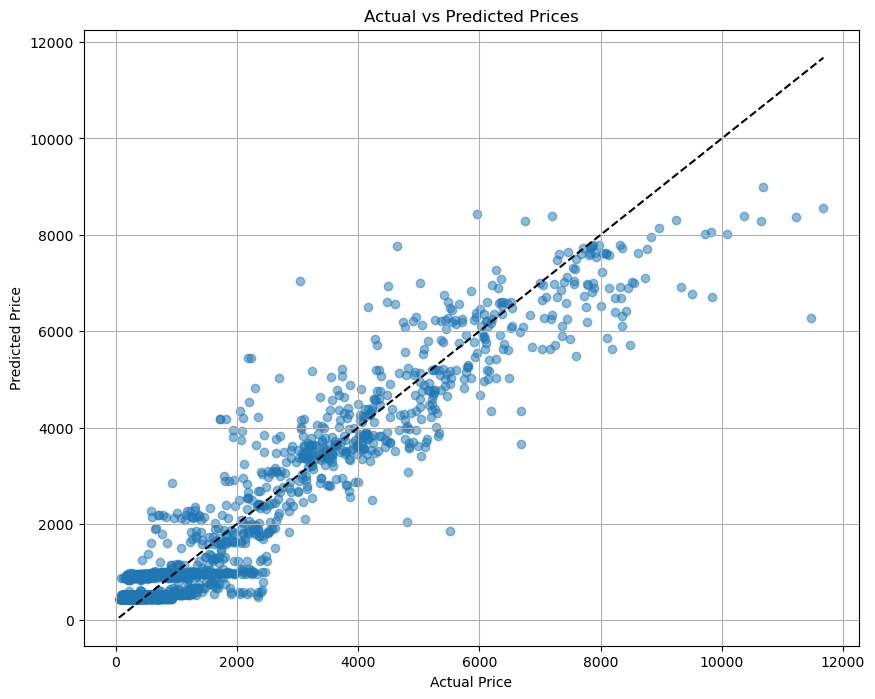

In [10]:
def plot_actual_vs_predicted(y_true, y_pred):
    plt.figure(figsize=(10, 8))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], 
             [y_true.min(), y_true.max()], 'k--')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title('Actual vs Predicted Prices')
    plt.grid(True)
    plt.savefig("rf_actual_vs_predicted.png")
    plt.show()

plot_actual_vs_predicted(y_test, y_pred_test)